In [81]:
#DATA PREPROCESSING

# Import necessary libraries
import pandas as pd
import numpy as np
import os

# Set the directory where CSV files are stored
data_dir = "/Users/charlie/diss"


# List of dataset file names
file_names = {
    "Clean Power Hydrogen": "Clean Power Hydrogen Stock Price History.csv",
    "NIFTY SME EMERGE": "NIFTY SME EMERGE_Historical_PR_01012010to01012025.csv",
    "Surana Solar": "Surana Solar Stock Price History.csv",
    "Solana": "Solana Historical Data.csv"
}

# Function to clean stock data
def clean_stock_data(df, date_column="Date", close_column="Close", date_format=None):
    # Convert date column to datetime format
    if date_format:
        df[date_column] = pd.to_datetime(df[date_column], format=date_format)
    else:
        df[date_column] = pd.to_datetime(df[date_column], errors='coerce')

    # Sort data in ascending order (oldest first)
    df = df.sort_values(by=date_column).reset_index(drop=True)

    # Keep only Date and Close Price
    df = df[[date_column, close_column]]

    # Rename columns for consistency
    df.columns = ["Date", "Close"]

    # Handle missing values (dropping rows with missing dates or close prices)
    df.dropna(inplace=True)

    return df

# Load and clean all datasets
dataframes = {}
for name, file in file_names.items():
    file_path = os.path.join(data_dir, file)
    
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Handle different date formats and Close price column names
    if name == "NIFTY SME EMERGE":
        df = clean_stock_data(df, date_format="%d %b %Y", close_column="Close")
    else:
        df = clean_stock_data(df, date_format="%m/%d/%Y", close_column="Price")

    dataframes[name] = df

# Display first few rows of each cleaned dataset
for name, df in dataframes.items():
    print(f"\n{name} - First 5 rows:\n", df.head())



Clean Power Hydrogen - First 5 rows:
         Date  Close
0 2022-02-17  63.01
1 2022-02-18  61.00
2 2022-02-21  60.00
3 2022-02-22  61.50
4 2022-02-23  62.50

NIFTY SME EMERGE - First 5 rows:
         Date    Close
0 2016-12-01  1000.00
1 2016-12-02   991.28
2 2016-12-05   984.78
3 2016-12-06   981.63
4 2016-12-07   975.89

Surana Solar - First 5 rows:
         Date  Close
0 2012-11-01  10.10
1 2012-11-05   9.75
2 2012-11-06   9.68
3 2012-11-07   9.88
4 2012-11-08   9.57

Solana - First 5 rows:
         Date  Close
0 2020-07-13  1.279
1 2020-07-14  1.115
2 2020-07-15  1.383
3 2020-07-21  1.004
4 2020-07-22  1.046


In [82]:
#SPLITTING DATA INTO TRAINING AND VALIDATION

# Splitting function (70% Training, 30% Validation)
def split_data(df, train_size=0.7):
    train_length = int(len(df) * train_size)  # Compute split index
    train = df.iloc[:train_length].copy()
    validation = df.iloc[train_length:].copy()
    return train, validation

# Split all datasets
train_sets = {}
validation_sets = {}

for name, df in dataframes.items():
    train_sets[name], validation_sets[name] = split_data(df)

# Display sample split results
for name in train_sets:
    print(f"\n{name} - Training Set Size: {len(train_sets[name])},
    Validation Set Size: {len(validation_sets[name])}")
    print(f"{name} - Training Set Preview:\n", train_sets[name].head())
    print(f"{name} - Validation Set Preview:\n", validation_sets[name].head())


Clean Power Hydrogen - Training Set Size: 506, Validation Set Size: 217
Clean Power Hydrogen - Training Set Preview:
         Date  Close
0 2022-02-17  63.01
1 2022-02-18  61.00
2 2022-02-21  60.00
3 2022-02-22  61.50
4 2022-02-23  62.50
Clean Power Hydrogen - Validation Set Preview:
           Date  Close
506 2024-02-22   8.15
507 2024-02-23  10.40
508 2024-02-26  12.65
509 2024-02-27  12.25
510 2024-02-28  11.25

NIFTY SME EMERGE - Training Set Size: 1403, Validation Set Size: 602
NIFTY SME EMERGE - Training Set Preview:
         Date    Close
0 2016-12-01  1000.00
1 2016-12-02   991.28
2 2016-12-05   984.78
3 2016-12-06   981.63
4 2016-12-07   975.89
NIFTY SME EMERGE - Validation Set Preview:
            Date    Close
1403 2022-07-28  4735.65
1404 2022-07-29  4747.12
1405 2022-08-01  4762.96
1406 2022-08-02  4744.17
1407 2022-08-03  4716.19

Surana Solar - Training Set Size: 2034, Validation Set Size: 872
Surana Solar - Training Set Preview:
         Date  Close
0 2012-11-01  10.10

In [83]:
#ARIMA


#importing models
#!pip install statsmodels==0.14.4
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Suppress warnings for better readability
warnings.filterwarnings("ignore")

# Define ARIMA order (p, d, q) - Placeholder values, we may need to tune these later
arima_order = (5, 1, 0)  # (5 lags, 1 differencing, 0 MA terms)

# Dictionary to store ARIMA models and predictions
arima_models = {}
arima_predictions = {}

# Train ARIMA for each dataset and make predictions
for name in train_sets:
    print(f"\nTraining ARIMA for {name}...")

    # Extract training and validation data
    train_data = train_sets[name].set_index("Date")["Close"]
    validation_data = validation_sets[name].set_index("Date")["Close"]

    # Instantiate and fit ARIMA model
    model = ARIMA(train_data, order=arima_order)
    fitted_model = model.fit()

    # Store the trained model
    arima_models[name] = fitted_model

    # Forecast for the validation set
    forecast = fitted_model.forecast(steps=len(validation_data))

    # Store predictions
    arima_predictions[name] = pd.DataFrame({
        "Date": validation_data.index,
        "Actual_Close": validation_data.values,
        "Predicted_Close": forecast.values
    }).set_index("Date")

    print(f"ARIMA training complete for {name}!")

# Display sample predictions
for name, pred_df in arima_predictions.items():
    print(f"\n{name} - Sample Predictions:\n", pred_df.head())



Training ARIMA for Clean Power Hydrogen...
ARIMA training complete for Clean Power Hydrogen!

Training ARIMA for NIFTY SME EMERGE...
ARIMA training complete for NIFTY SME EMERGE!

Training ARIMA for Surana Solar...
ARIMA training complete for Surana Solar!

Training ARIMA for Solana...
ARIMA training complete for Solana!

Clean Power Hydrogen - Sample Predictions:
             Actual_Close  Predicted_Close
Date                                     
2024-02-22          8.15         7.985099
2024-02-23         10.40         7.984387
2024-02-26         12.65         7.986058
2024-02-27         12.25         7.996323
2024-02-28         11.25         7.985228

NIFTY SME EMERGE - Sample Predictions:
             Actual_Close  Predicted_Close
Date                                     
2022-07-28       4735.65      4761.384929
2022-07-29       4747.12      4773.266214
2022-08-01       4762.96      4781.065672
2022-08-02       4744.17      4781.613823
2022-08-03       4716.19      4785.482006

S

In [84]:
#GARCH

# Suppress warnings for better readability
warnings.filterwarnings("ignore")

# Import necessary libraries
from arch import arch_model


# Dictionary to store GARCH models and predictions
garch_models = {}
garch_predictions = {}

# Train GARCH(1,1) for each dataset and make predictions
for name in train_sets:
    print(f"\nTraining GARCH for {name}...")

    # Extract training and validation data
    train_data = train_sets[name].set_index("Date")["Close"]
    validation_data = validation_sets[name].set_index("Date")["Close"]

    # Calculate returns (log difference for stationarity)
    train_returns = np.log(train_data).diff().dropna()

    # Instantiate and fit GARCH(1,1) model
    model = arch_model(train_returns, vol="Garch", p=1, q=1)
    fitted_model = model.fit(disp="off")  # Suppress output for cleaner display

    # Store the trained model
    garch_models[name] = fitted_model

    # Define forecast parameters
    forecast_horizon = len(validation_data)
    forecast_start = max(0, len(train_returns) - 1)  # Ensure start index is within range

    # Perform the GARCH forecast
    forecasts = fitted_model.forecast(start=forecast_start, horizon=forecast_horizon, reindex=False)

    # Ensure forecast horizon does not exceed available data
    available_variance = forecasts.variance.shape[1]  # Check available forecasted periods
    forecast_horizon = min(forecast_horizon, available_variance)  

    # Extract the predicted variances
    predicted_variances = forecasts.variance.iloc[-1, :forecast_horizon].values.flatten()
    predicted_volatility = np.sqrt(predicted_variances)

    # Generate synthetic returns using predicted volatility
    np.random.seed(42)  # For reproducibility
    simulated_returns = np.random.normal(loc=train_returns.mean(), scale=predicted_volatility)

    # Convert simulated returns into cumulative predicted price movements
    predicted_prices = [train_data.iloc[-1]]  # Start from last observed training price
    for i in range(forecast_horizon):
        next_price = predicted_prices[-1] * np.exp(simulated_returns[i])
        predicted_prices.append(next_price)

    # Remove the first value (initial training price) and convert to DataFrame
    predicted_prices = predicted_prices[1:]

    # Store predictions
    garch_predictions[name] = pd.DataFrame({
        "Date": validation_data.index[:forecast_horizon],  # Ensure matching lengths
        "Actual_Close": validation_data.values[:forecast_horizon],
        "Predicted_Close": predicted_prices
    }).set_index("Date")

    print(f"GARCH training complete for {name}!")

# Display sample predictions
for name, pred_df in garch_predictions.items():
    print(f"\n{name} - Sample Predictions:\n", pred_df.head())



Training GARCH for Clean Power Hydrogen...
GARCH training complete for Clean Power Hydrogen!

Training GARCH for NIFTY SME EMERGE...
GARCH training complete for NIFTY SME EMERGE!

Training GARCH for Surana Solar...
GARCH training complete for Surana Solar!

Training GARCH for Solana...
GARCH training complete for Solana!

Clean Power Hydrogen - Sample Predictions:
             Actual_Close  Predicted_Close
Date                                     
2024-02-22          8.15         8.091926
2024-02-23         10.40         8.021287
2024-02-26         12.65         8.173776
2024-02-27         12.25         8.603183
2024-02-28         11.25         8.494468

NIFTY SME EMERGE - Sample Predictions:
             Actual_Close  Predicted_Close
Date                                     
2022-07-28       4735.65      4770.654577
2022-07-29       4747.12      4770.335204
2022-08-01       4762.96      4802.116494
2022-08-02       4744.17      4870.516885
2022-08-03       4716.19      4866.147468

S

In [85]:
#SVR

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
warnings.filterwarnings("ignore")

# Setting lag window size
lag_window = 5

# Storage
svr_models = {}
svr_predictions = {}

for name in train_sets:
    print(f"\n Training SVR for {name}...")

    # Prepare training close prices
    train_prices = train_sets[name]["Close"].reset_index(drop=True).copy()
    val_prices = validation_sets[name]["Close"].reset_index(drop=True).copy()
    val_dates = validation_sets[name]["Date"]

    # Create lagged features for training
    X_train, y_train = [], []
    for i in range(lag_window, len(train_prices)):
        X_train.append(train_prices.iloc[i - lag_window:i].values)
        y_train.append(train_prices.iloc[i])
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Scale inputs
    scaler_x = StandardScaler()
    scaler_y = MinMaxScaler()

    X_train_scaled = scaler_x.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

    # Train model
    svr_model = SVR(kernel='rbf')
    svr_model.fit(X_train_scaled, y_train_scaled)

    # Store the trained model
    svr_models[name] = svr_model

    # Prepare recursive prediction base 
    history = train_prices.iloc[-lag_window:].tolist()
    predictions = []

    # Generate predictions after appending previous one to training data
    for i in range(len(val_prices)):
        X_input = np.array(history[-lag_window:]).reshape(1, -1)
        X_scaled = scaler_x.transform(X_input)
        pred_scaled = svr_model.predict(X_scaled)[0]
        pred = scaler_y.inverse_transform([[pred_scaled]])[0, 0]

        predictions.append(pred)
        history.append(pred)  # roll the prediction forward

    # Store prediction output
    df_preds = pd.DataFrame({
        "Date": list(val_dates)[:len(predictions)],
        "Actual_Close": list(val_prices)[:len(predictions)],
        "Predicted_Close": predictions
    }).set_index("Date")

    svr_predictions[name] = df_preds
    print(f"GARCH training complete for {name}!")
    
    # Display sample predictions
for name, df_preds in svr_predictions.items():
    print(f"\n{name} - Sample Predictions:\n", df_preds.head())



 Training SVR for Clean Power Hydrogen...
GARCH training complete for Clean Power Hydrogen!

 Training SVR for NIFTY SME EMERGE...
GARCH training complete for NIFTY SME EMERGE!

 Training SVR for Surana Solar...
GARCH training complete for Surana Solar!

 Training SVR for Solana...
GARCH training complete for Solana!

Clean Power Hydrogen - Sample Predictions:
             Actual_Close  Predicted_Close
Date                                     
2024-02-22          8.15        15.020694
2024-02-23         10.40        15.925927
2024-02-26         12.65        16.987279
2024-02-27         12.25        18.250912
2024-02-28         11.25        19.760347

NIFTY SME EMERGE - Sample Predictions:
             Actual_Close  Predicted_Close
Date                                     
2022-07-28       4735.65      4521.339273
2022-07-29       4747.12      4492.634914
2022-08-01       4762.96      4463.629978
2022-08-02       4744.17      4429.533699
2022-08-03       4716.19      4395.674327

Suran

In [86]:
#EVALUATION

# Import necessary libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Dictionary to store error metrics
model_errors = {}

# Function to calculate error metrics
def calculate_errors(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100  # Convert to percentage
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "MAPE": mape}

# Evaluate ARIMA
print("Predicting ARIMA Model Errors...")
for name, pred_df in arima_predictions.items():
    errors = calculate_errors(pred_df["Actual_Close"], pred_df["Predicted_Close"])
    model_errors[f"ARIMA_{name}"] = errors


# Evaluate GARCH
print("Predicting GARCH Model Errors...")
for name, pred_df in garch_predictions.items():
    errors = calculate_errors(pred_df["Actual_Close"], pred_df["Predicted_Close"])
    model_errors[f"GARCH_{name}"] = errors


# Evaluate SVR
print("Predicting SVR Model Errors...")
for name, df_preds in svr_predictions.items():
    errors = calculate_errors(df_preds["Actual_Close"], df_preds["Predicted_Close"])
    model_errors[f"SVR_{name}"] = errors


# Convert to DataFrame for easy viewing
error_df = pd.DataFrame(model_errors).T

from IPython.display import display
# Create and format DataFrame
error_df = pd.DataFrame(model_errors).T
error_df = error_df.round(2)  # Round all values to 2 decimal places

# Display cleanly
display(error_df)


Predicting ARIMA Model Errors...
Predicting GARCH Model Errors...
Predicting SVR Model Errors...


,MSE,RMSE,MAE,MAPE
ARIMA_Clean Power Hydrogen,17.17,4.14,2.95,22.72
ARIMA_NIFTY SME EMERGE,43752492.52,6614.57,5441.49,46.18
ARIMA_Surana Solar,368.91,19.21,15.96,51.24
ARIMA_Solana,15252.04,123.50,108.50,75.27
GARCH_Clean Power Hydrogen,49.88,7.06,6.79,62.84
GARCH_NIFTY SME EMERGE,18390210.24,4288.38,3540.99,30.68
GARCH_Surana Solar,415.65,20.39,16.87,54.48
GARCH_Solana,8922.46,94.46,83.57,64.71
SVR_Clean Power Hydrogen,801.39,28.31,27.80,280.93
SVR_NIFTY SME EMERGE,65974006.01,8122.44,7165.66,65.15


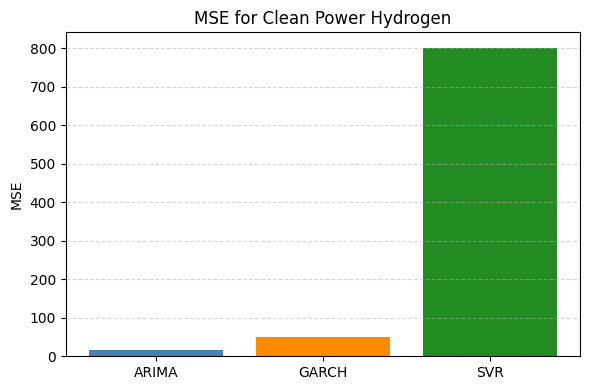

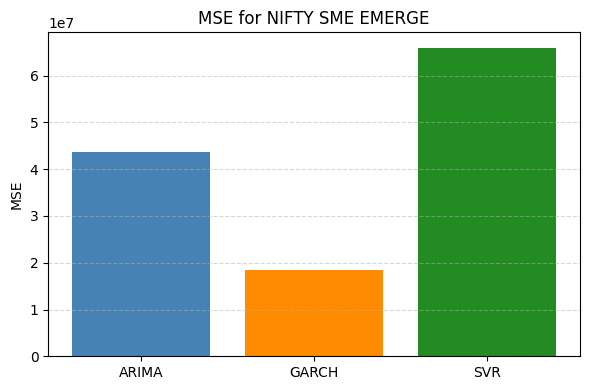

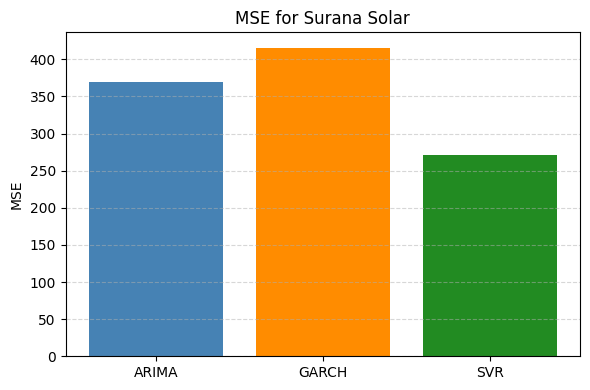

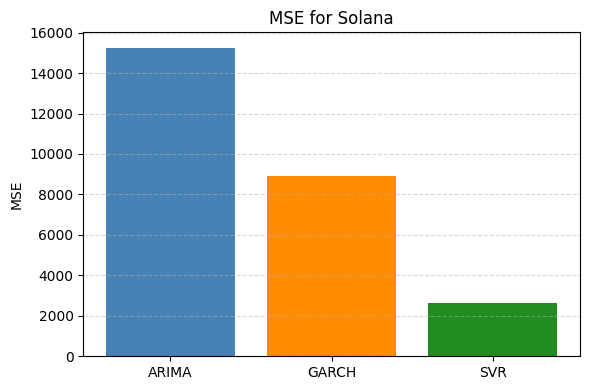

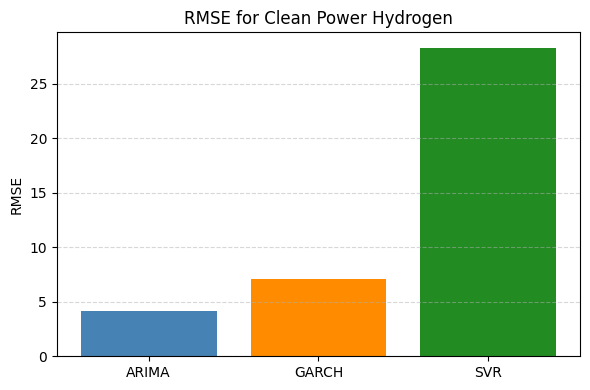

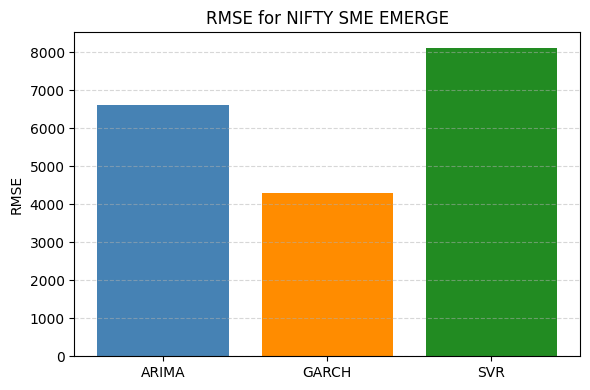

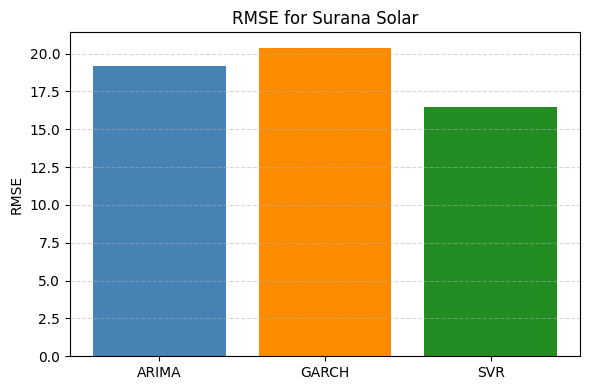

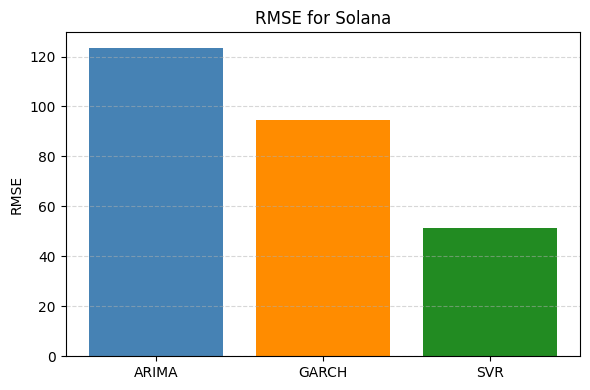

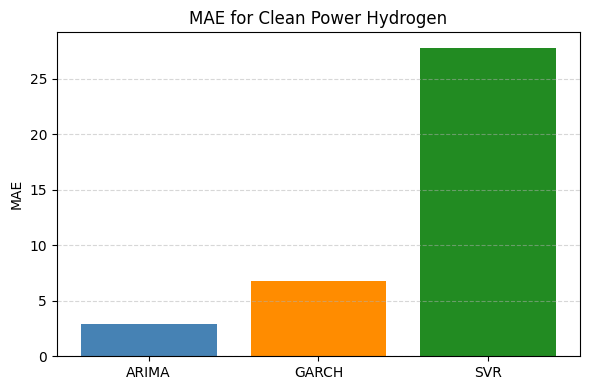

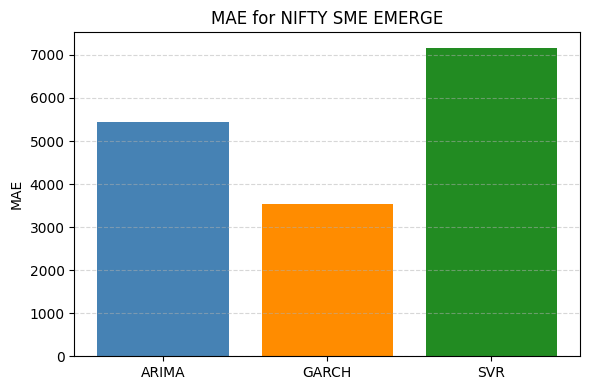

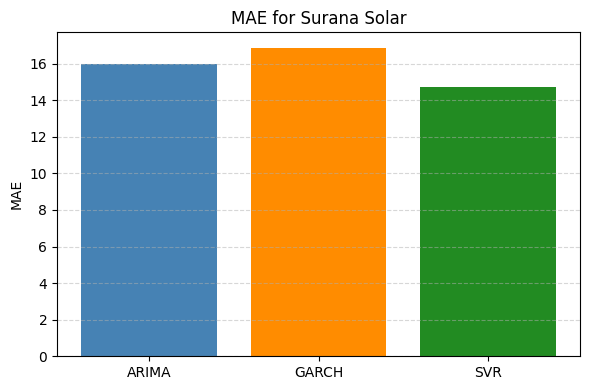

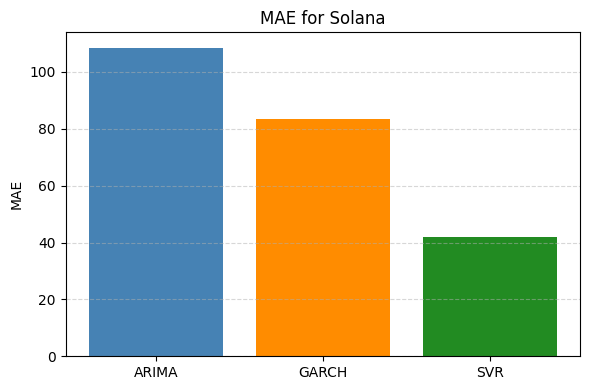

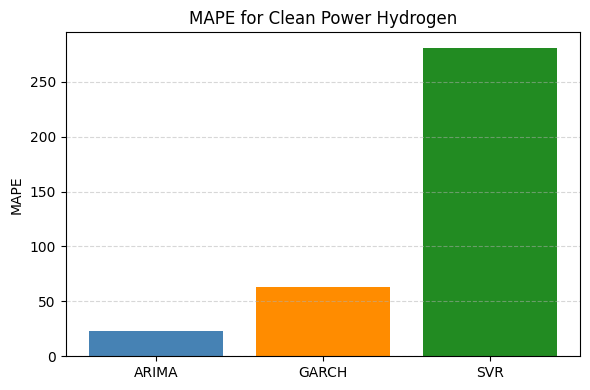

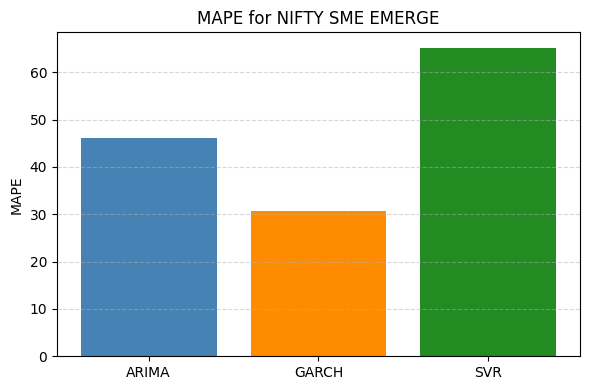

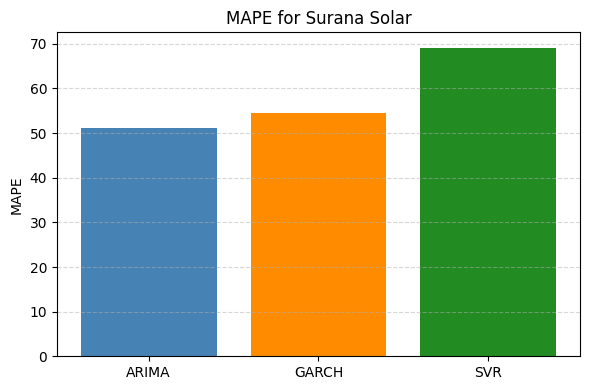

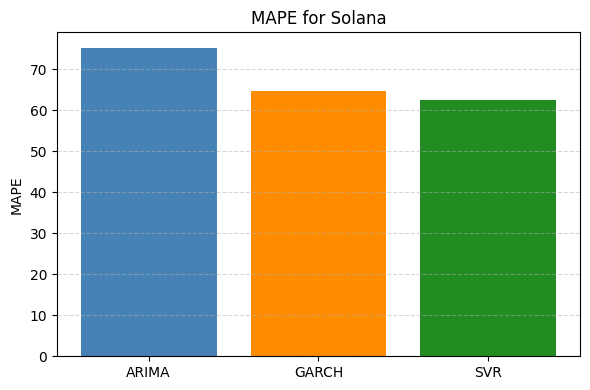

In [87]:

import matplotlib.pyplot as plt
def plot_error_bars(error_df, metric):
    datasets = ['Clean Power Hydrogen', 'NIFTY SME EMERGE', 'Surana Solar', 'Solana']
    models = ['ARIMA', 'GARCH', 'SVR']

    for dataset in datasets:
        values = []
        for model in models:
            key = f"{model}_{dataset}"
            values.append(error_df.loc[key, metric])

        plt.figure(figsize=(6, 4))
        plt.bar(models, values, color=["steelblue", "darkorange", "forestgreen"])
        plt.title(f"{metric} for {dataset}")
        plt.ylabel(metric)
        plt.grid(axis="y", linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()


for metric in ["MSE", "RMSE", "MAE", "MAPE"]:
    plot_error_bars(error_df, metric)




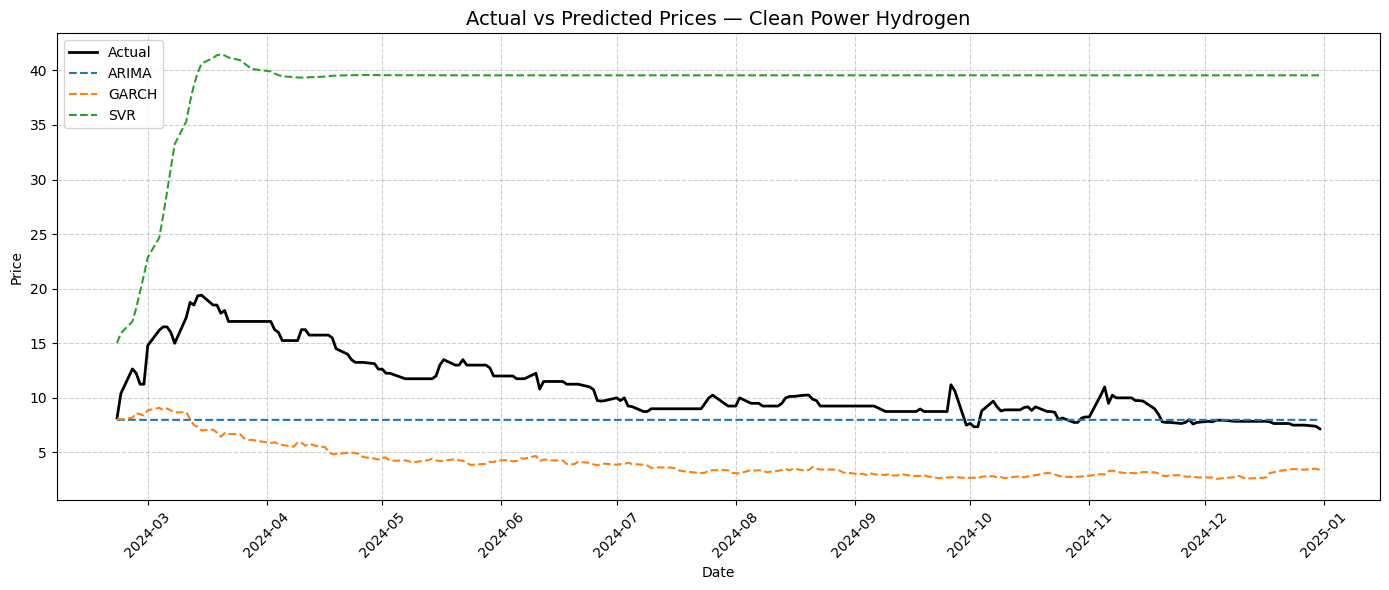

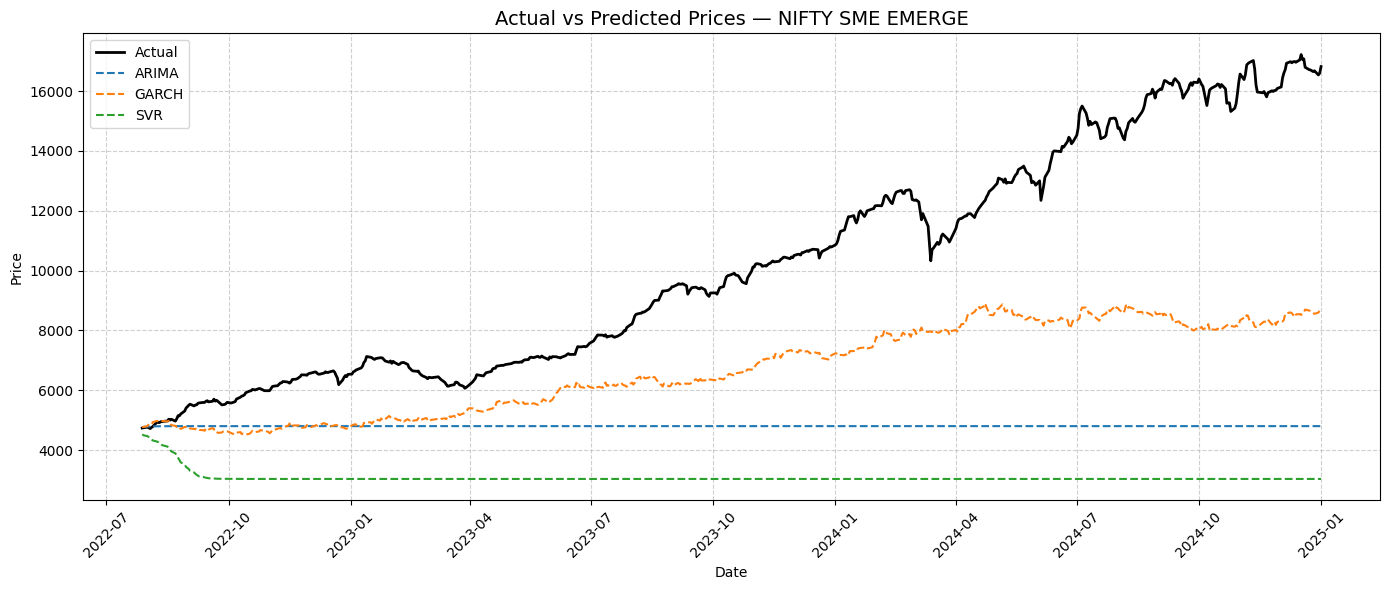

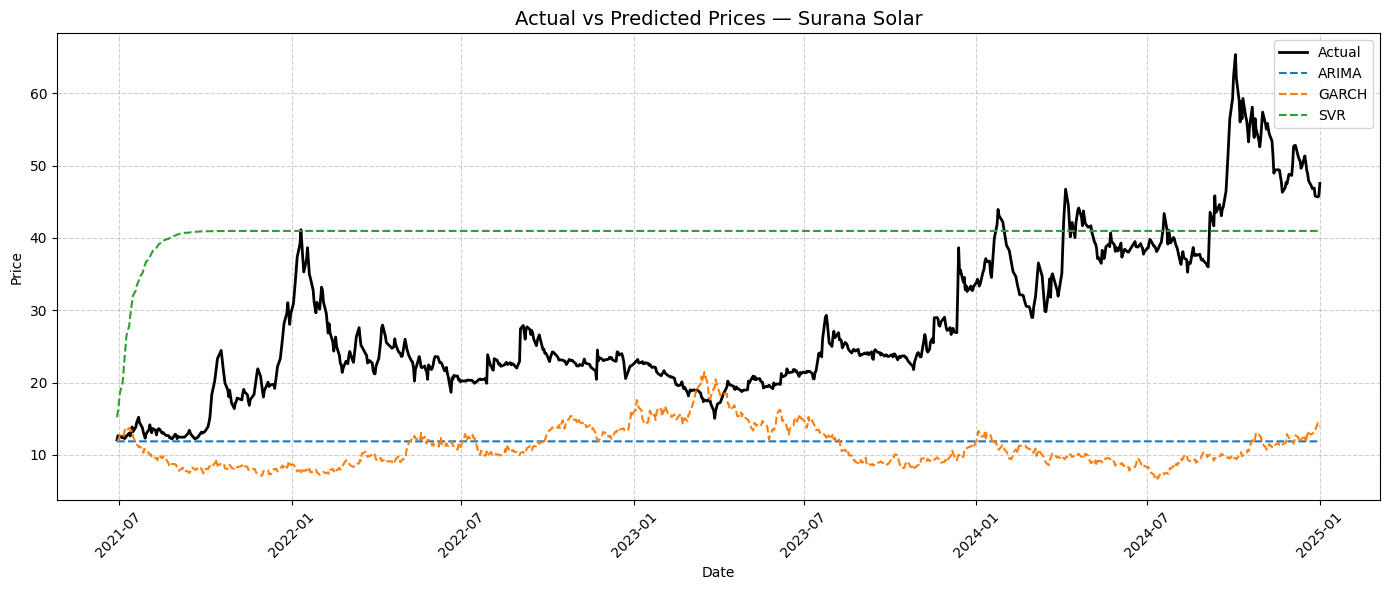

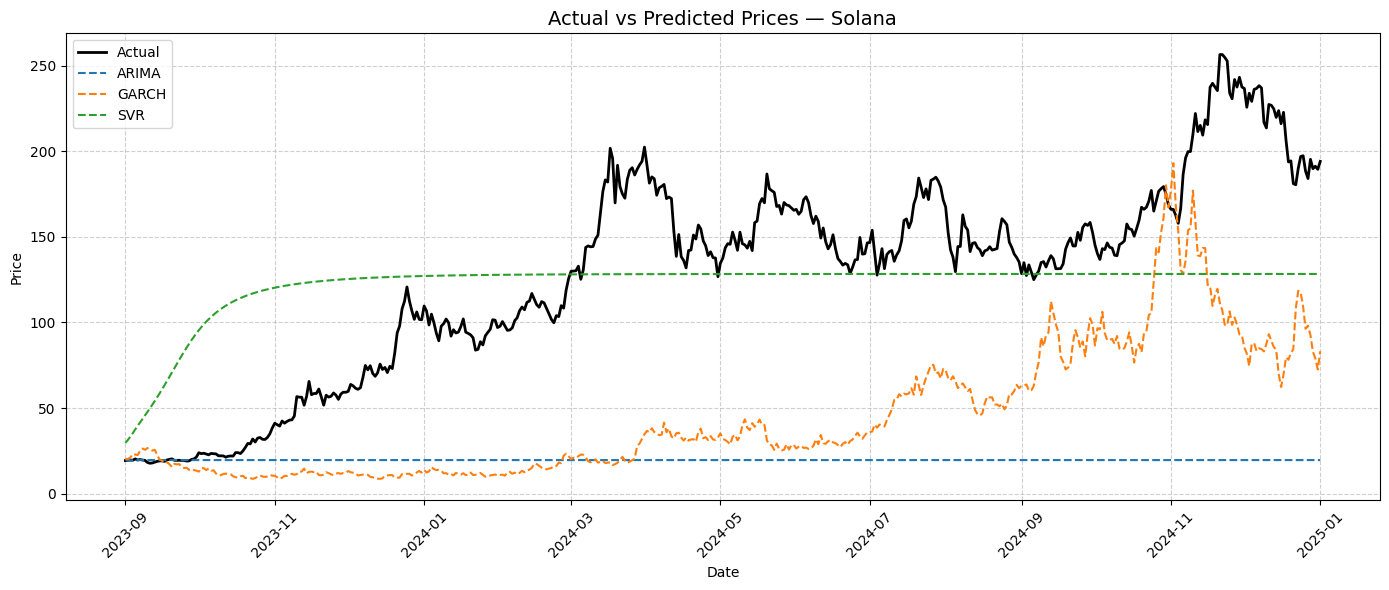

In [88]:
unified_predictions = {}
datasets = ['Clean Power Hydrogen', 'NIFTY SME EMERGE', 'Surana Solar', 'Solana']
for name in datasets:
    arima_df = arima_predictions[name].rename(columns={"Predicted_Close": "ARIMA_Pred"})
    garch_df = garch_predictions[name].rename(columns={"Predicted_Close": "GARCH_Pred"})
    svr_df = svr_predictions[name].rename(columns={"Predicted_Close": "SVR_Pred"})

    merged_df = arima_df[["Actual_Close", "ARIMA_Pred"]].copy()
    merged_df["GARCH_Pred"] = garch_df["GARCH_Pred"]
    merged_df["SVR_Pred"] = svr_df["SVR_Pred"]
    merged_df = merged_df.reset_index().rename(columns={"Actual_Close": "Actual"})

    unified_predictions[name] = merged_df
def plot_predictions(df, dataset_name):
    plt.figure(figsize=(14, 6))
    
    # Plot actual prices
    plt.plot(df['Date'], df['Actual'], label='Actual', color='black', linewidth=2)
    
    # Plot predictions from each model
    plt.plot(df['Date'], df['ARIMA_Pred'], label='ARIMA', linestyle='--')
    plt.plot(df['Date'], df['GARCH_Pred'], label='GARCH', linestyle='--')
    plt.plot(df['Date'], df['SVR_Pred'], label='SVR', linestyle='--')
    
    # Formatting
    plt.title(f'Actual vs Predicted Prices — {dataset_name}', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_predictions(unified_predictions['Clean Power Hydrogen'], 'Clean Power Hydrogen')
plot_predictions(unified_predictions['NIFTY SME EMERGE'], 'NIFTY SME EMERGE')
plot_predictions(unified_predictions['Surana Solar'], 'Surana Solar')
plot_predictions(unified_predictions['Solana'], 'Solana')


 Tuning + Forecasting for Clean Power Hydrogen...
 Best ARIMA order for Clean Power Hydrogen: (2, 1, 3), AIC: 1723.8465573412686


100%|█████████████████████████████████████████| 217/217 [00:43<00:00,  4.94it/s]


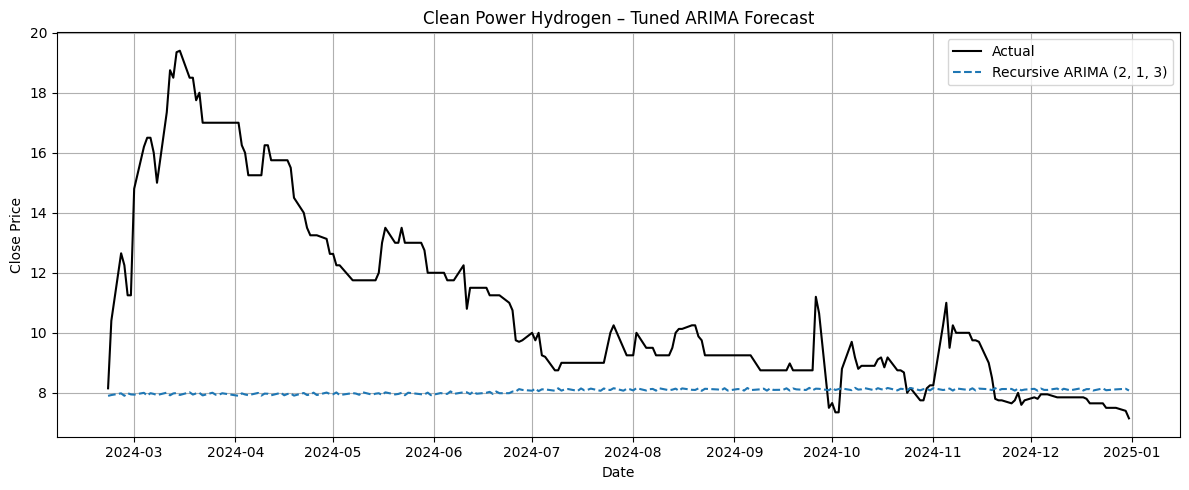


 Tuning + Forecasting for NIFTY SME EMERGE...
 Best ARIMA order for NIFTY SME EMERGE: (3, 1, 3), AIC: 12575.185026549429


 93%|█████████████████████████████████████▉   | 557/602 [05:19<00:29,  1.53it/s]

In [ ]:
#TUNED ARIMA

import itertools
from tqdm import tqdm
# Grid of (p,d,q) to search
pdq_grid = list(itertools.product(range(0, 4), [0, 1], range(0, 4)))
recursive_results = {}

for stock in dataframes.keys():
    print(f"\n Tuning + Forecasting for {stock}...")

    # Extract train and validation
    train_series = train_sets[stock].set_index("Date")["Close"]
    val_series = validation_sets[stock].set_index("Date")["Close"]

    # Tune on training set
    best_order = None
    best_aic = float("inf")

    for order in pdq_grid:
        try:
            model = ARIMA(train_series, order=order)
            result = model.fit()
            if result.aic < best_aic:
                best_aic = result.aic
                best_order = order
        except:
            continue

    print(f" Best ARIMA order for {stock}: {best_order}, AIC: {best_aic}")

    # Recursive forecasting using only predictions
    history = train_series.copy()
    predictions = []

    for t in tqdm(range(len(val_series))):
        try:
            model = ARIMA(history, order=best_order)
            model_fit = model.fit()
            yhat = model_fit.forecast(steps=1).iloc[0]
        except:
            yhat = history.iloc[-1]  
        predictions.append(yhat)
        history = pd.concat([history, pd.Series([yhat], index=[val_series.index[t]])])

    # Store predictions
    result_df = pd.DataFrame({
        "Date": val_series.index,
        "Actual_Close": val_series.values,
        "Recursive_ARIMA_Predicted_Close": predictions
    }).set_index("Date")

    recursive_results[stock] = result_df

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(result_df.index, result_df["Actual_Close"], label="Actual", color="black")
    plt.plot(result_df.index, result_df["Recursive_ARIMA_Predicted_Close"],
             label=f"Recursive ARIMA {best_order}", linestyle="--")
    plt.title(f"{stock} – Tuned ARIMA Forecast")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



 MSE-based GARCH tuning for Clean Power Hydrogen...


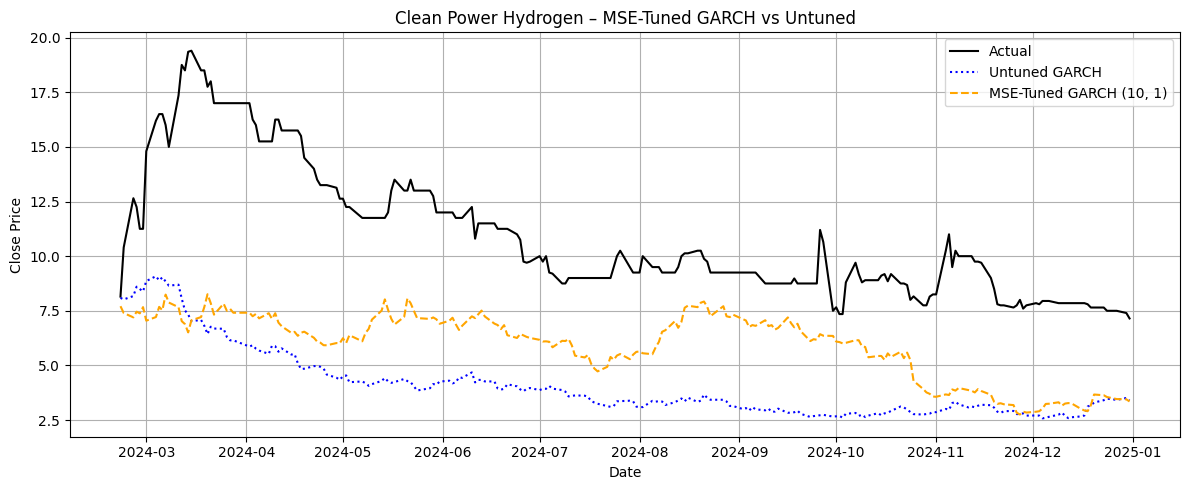


 MSE-based GARCH tuning for NIFTY SME EMERGE...


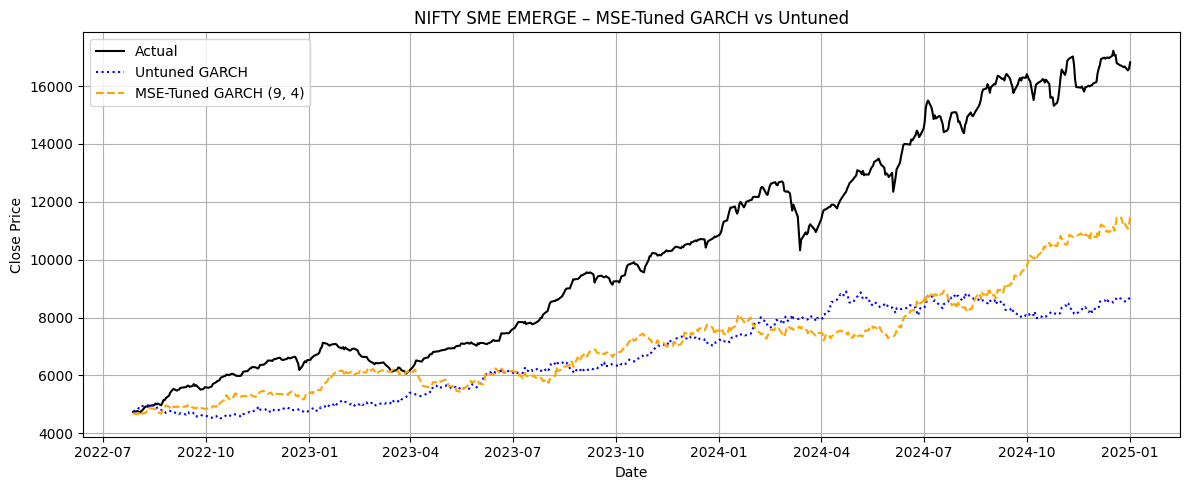


 MSE-based GARCH tuning for Surana Solar...


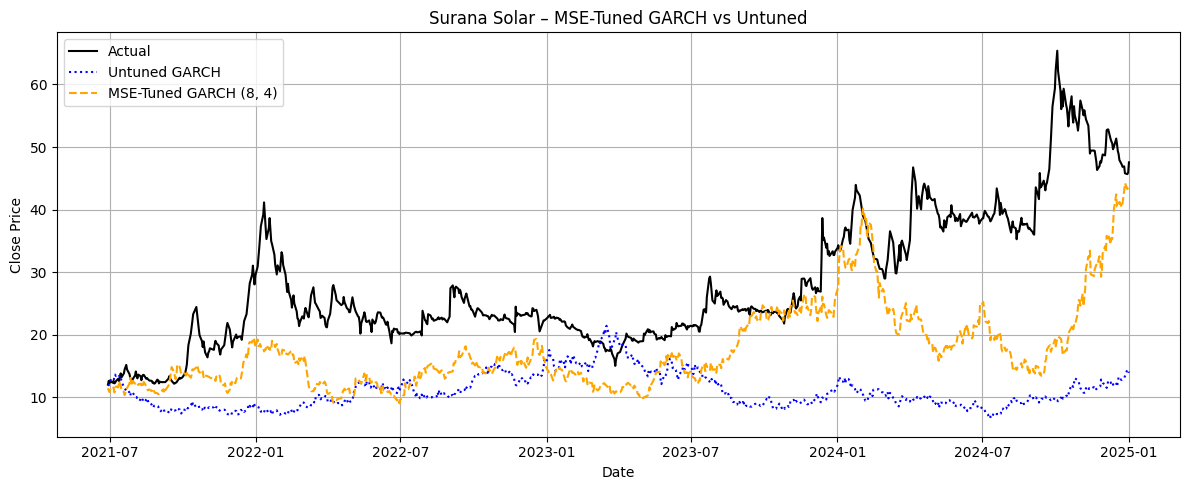


 MSE-based GARCH tuning for Solana...


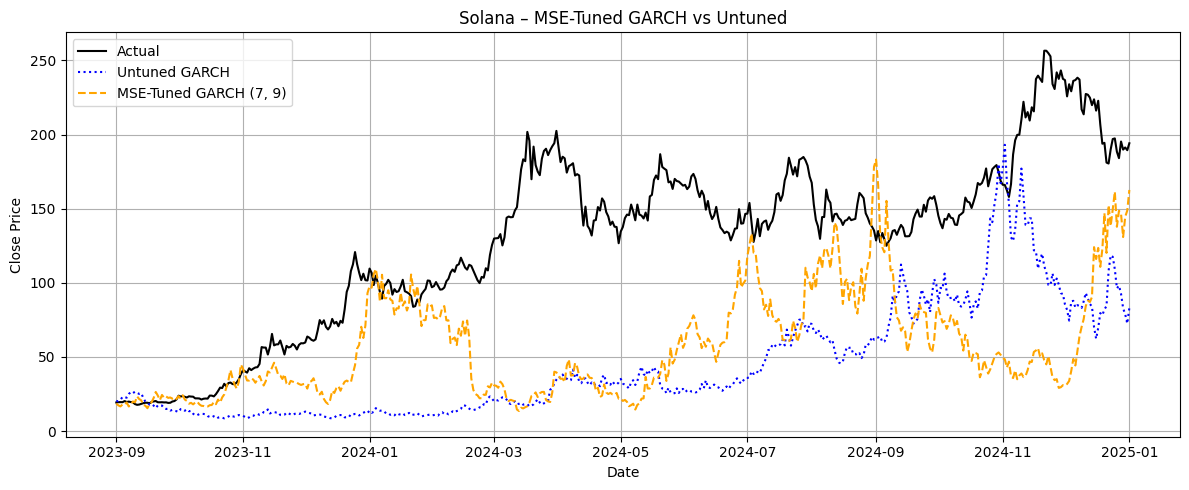

In [109]:
#TUNED GARCH

# Storage for final tuned GARCH models and predictions
final_mse_garch_models = {}
final_mse_garch_predictions = {}

# Loop through each dataset
for name in train_sets:
    print(f"\n MSE-based GARCH tuning for {name}...")

    # Extract data
    train_data = train_sets[name].set_index("Date")["Close"]
    val_data = validation_sets[name].set_index("Date")["Close"]
    forecast_horizon = len(val_data)

    # Get log returns from training set
    returns = np.log(train_data).diff().dropna()
    mean_return = returns.mean()

    # Initialise best values
    best_mse = float("inf")
    best_model = None
    best_order = None
    best_synthetic_returns = None

    # Grid search (p, q)
    for p in range(0, 11):
        for q in range(0, 11):
            try:
                model = arch_model(returns, vol="Garch", p=p, q=q)
                fit = model.fit(disp="off")

                # Forecast volatility
                forecast = fit.forecast(horizon=forecast_horizon, reindex=False)
                forecast_vol = np.sqrt(forecast.variance.values[-1])

                # Generate synthetic returns using correct method
                np.random.seed(48)
                synthetic_returns = np.random.normal(
                    loc=mean_return,
                    scale=forecast_vol
                )

                # Reconstruct synthetic close prices
                prices = [train_data.iloc[-1]]
                for r in synthetic_returns:
                    prices.append(prices[-1] * np.exp(r))
                synthetic_prices = prices[1:]

                # Calculate MSE against actual validation prices
                mse = mean_squared_error(val_data.values, synthetic_prices)

                # Save if best
                if mse < best_mse:
                    best_mse = mse
                    best_model = fit
                    best_order = (p, q)
                    best_synthetic_returns = synthetic_returns

            except Exception:
                continue

    # Final synthetic price path using best returns
    final_prices = [train_data.iloc[-1]]
    for r in best_synthetic_returns:
        final_prices.append(final_prices[-1] * np.exp(r))
    final_prices = final_prices[1:]

    # Save model and predictions
    final_mse_garch_models[name] = best_model
    prediction_df = pd.DataFrame({
        "Date": val_data.index,
        "Actual_Close": val_data.values,
        "MSE_GARCH_Predicted_Close": final_prices
    }).set_index("Date")
    
    final_mse_garch_predictions[name] = prediction_df

    # Plot alongside untuned GARCH
    plt.figure(figsize=(12, 5))
    plt.plot(prediction_df.index, prediction_df["Actual_Close"], label="Actual", color="black")

    if name in garch_predictions:
        untuned_df = garch_predictions[name]
        untuned_col = (
            "Predicted_Close" if "Predicted_Close" in untuned_df.columns
            else list(untuned_df.columns)[-1]
        )
        plt.plot(untuned_df.index, untuned_df[untuned_col], label="Untuned GARCH", linestyle=":", color="blue")

    plt.plot(prediction_df.index, final_mse_garch_predictions[name]["MSE_GARCH_Predicted_Close"],
             label=f"MSE-Tuned GARCH {best_order}", linestyle="--", color="orange")

    plt.title(f"{name} – MSE-Tuned GARCH vs Untuned")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



 Best config for Clean Power Hydrogen: lag=175, C=10, ε=0.1, γ=0.01 | MSE=3.9493

 Best config for NIFTY SME EMERGE: lag=145, C=100, ε=0.01, γ=0.01 | MSE=43962777.2122

 Best config for Surana Solar: lag=395, C=1, ε=0.1, γ=0.1 | MSE=66.4334

 Best config for Solana: lag=35, C=10, ε=0.01, γ=0.1 | MSE=1355.4927


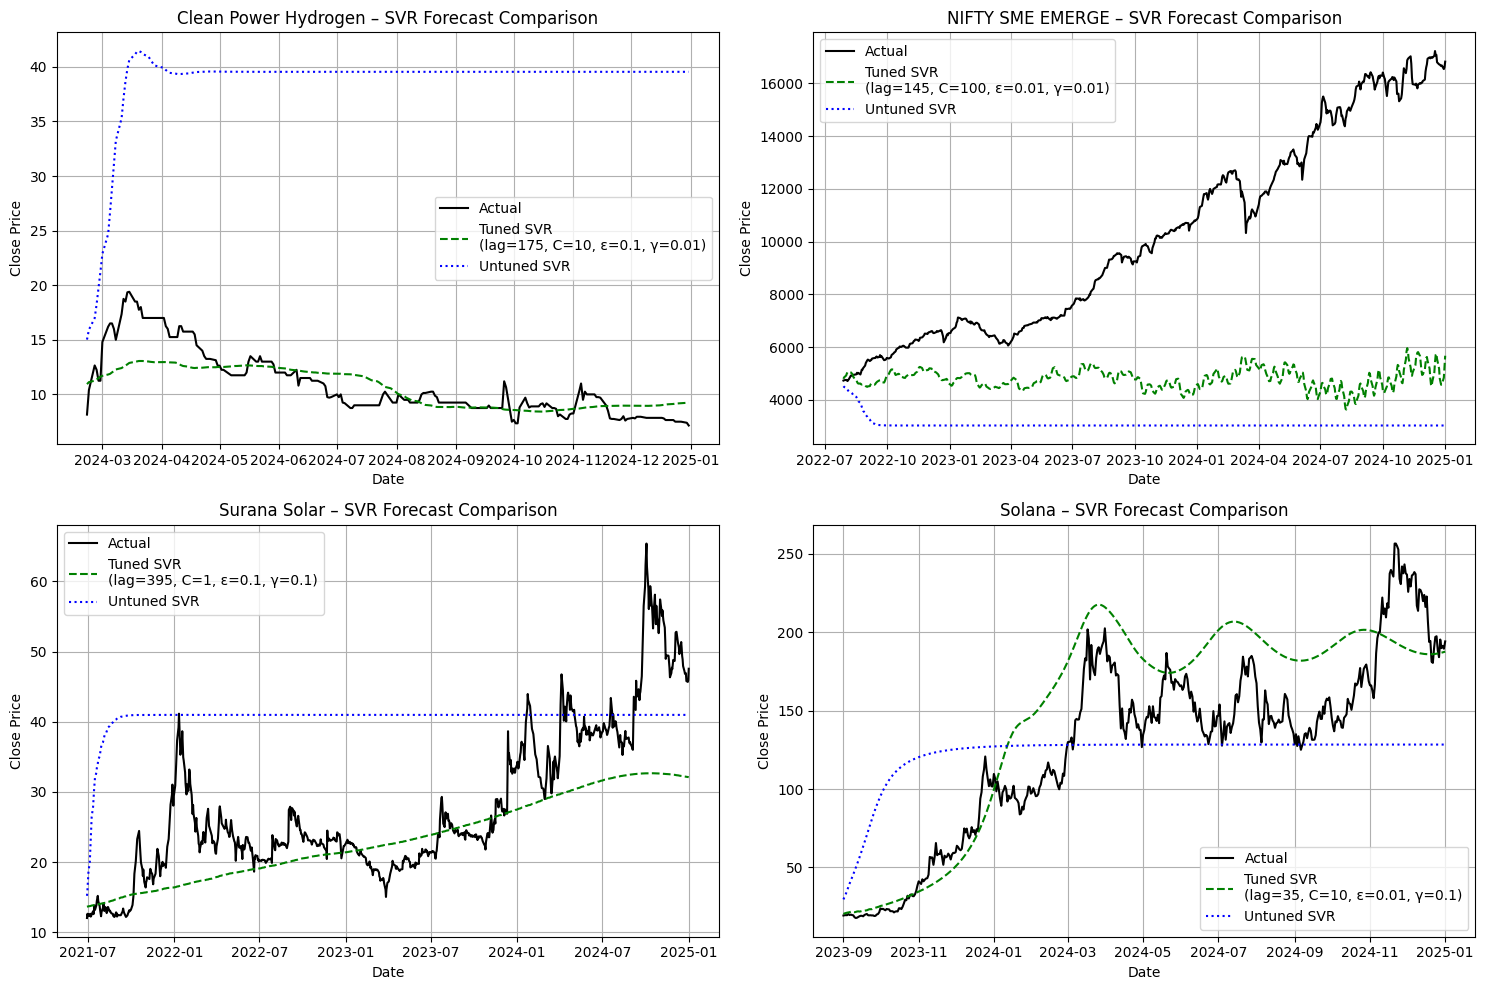

In [100]:
#TUNED SVR

def recursive_svr_predict(train_prices, val_prices, lag_window, C, epsilon, gamma):
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train = np.array([train_prices[i - lag_window:i] for i in range(lag_window, len(train_prices))])
    y_train = np.array(train_prices[lag_window:])
    X_scaled = scaler_x.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

    model = SVR(C=C, epsilon=epsilon, gamma=gamma)
    model.fit(X_scaled, y_scaled)

    history = train_prices[-lag_window:].tolist()
    predictions = []

    for _ in range(len(val_prices)):
        X_input = np.array(history[-lag_window:]).reshape(1, -1)
        X_scaled = scaler_x.transform(X_input)
        pred_scaled = model.predict(X_scaled)[0]
        pred = scaler_y.inverse_transform([[pred_scaled]])[0, 0]
        predictions.append(pred)
        history.append(pred)

    return predictions

def tune_svr_all_datasets(dataset_dict, lag_range=range(15, 995, 10),
                          C_vals=[1, 10, 100], eps_vals=[0.01, 0.1],
                          gamma_vals=['scale', 0.01, 0.1]):
    results = {}
    for name, df in dataset_dict.items():
        df = df.sort_values("Date")
        prices = df["Close"].values.reshape(-1, 1)
        dates = df["Date"].values
        split = int(len(prices) * 0.7)
        train_prices = prices[:split].flatten()
        val_prices = prices[split:].flatten()
        val_dates = dates[split:]
        best_mse = float("inf")
        best_config = None
        best_predictions = None
        for lag in lag_range:
            for C in C_vals:
                for epsilon in eps_vals:
                    for gamma in gamma_vals:
                        try:
                            # Generate lagged features from training prices
                            X, y = create_lagged_features(train_prices, lag)
                    
                            # Skip if lag too large or data insufficient
                            if X is None or len(X) == 0 or len(prices) <= lag + 1:
                                continue
                            # Reshape to 2D
                            X = np.array(X).reshape(-1, lag)
                            y = np.array(y).reshape(-1, 1)
                            # Perform recursive SVR prediction on validation set
                            preds = recursive_svr_predict(train_prices, val_prices, lag, C, epsilon, gamma)
                            # Calculate MSE
                            mse = mean_squared_error(val_prices, preds)
                            # Keep track of best model
                            if mse < best_mse:
                                best_mse = mse
                                best_config = (lag, C, epsilon, gamma)
                                best_predictions = preds
                        except Exception as e:
                            print(f"[{name}] Error for lag={lag}, C={C}, epsilon={epsilon}, gamma={gamma}: {e}")
                            continue

        results[name] = {
            "val_dates": val_dates,
            "actual": val_prices,
            "predicted": best_predictions,
            "config": best_config,
            "mse": best_mse
        }

        print(f"\n Best config for {name}: lag={best_config[0]}, C={best_config[1]},
        ε={best_config[2]}, γ={best_config[3]} | MSE={best_mse:.4f}")

    return results

def create_lagged_features(series, lag):
    
    X, y = [], []
    for i in range(len(series) - lag):
        X.append(series[i:i+lag])
        y.append(series[i+lag])
    return X, y



def plot_svr_tuned_all(results, untuned_results=None):
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    for i, (name, res) in enumerate(results.items()):
        ax = axes[i]

        ax.plot(res["val_dates"], res["actual"], label="Actual", color="black")
        ax.plot(res["val_dates"], res["predicted"],
                label=f"Tuned SVR\n(lag={res['config'][0]}, C={res['config'][1]},
                ε={res['config'][2]}, γ={res['config'][3]})",
                linestyle="--", color="green")

        # Plot untuned SVR 
        if untuned_results and name in untuned_results:
            ax.plot(untuned_results[name].index,
                    untuned_results[name]["Predicted_Close"],
                    label="Untuned SVR", linestyle=":", color="blue")

        ax.set_title(f"{name} – SVR Forecast Comparison")
        ax.set_xlabel("Date")
        ax.set_ylabel("Close Price")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()



svr_tuned_results = tune_svr_all_datasets(dataframes)
plot_svr_tuned_all(svr_tuned_results, untuned_results=svr_predictions)


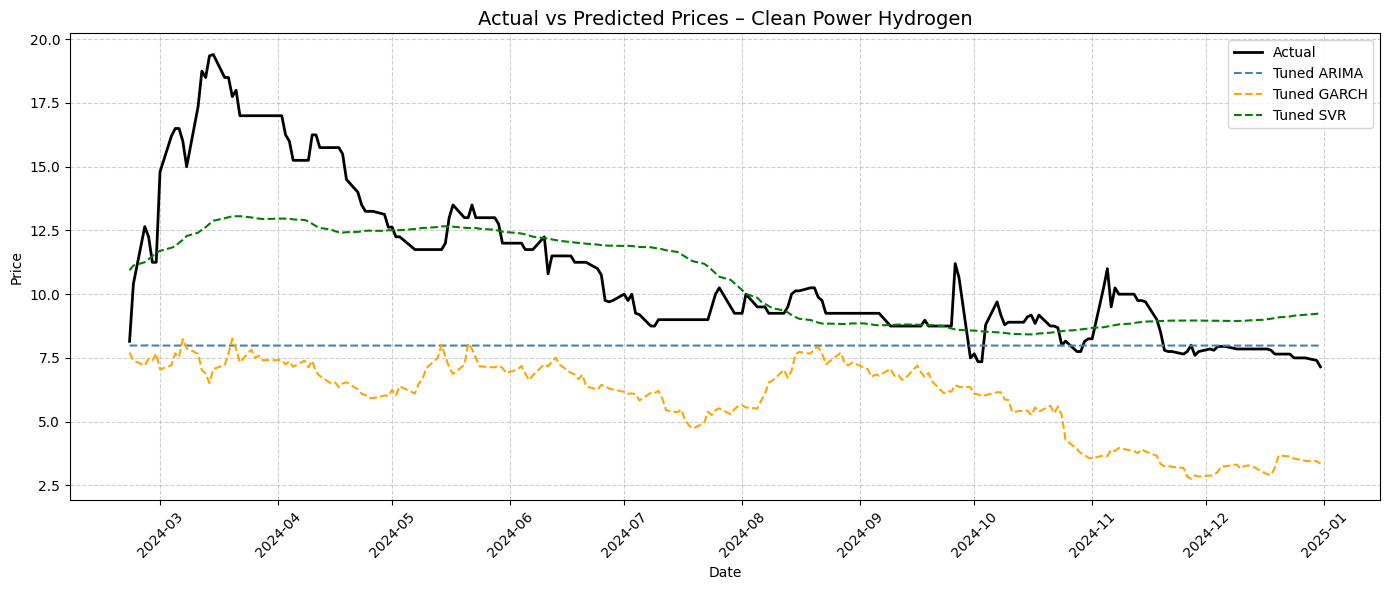

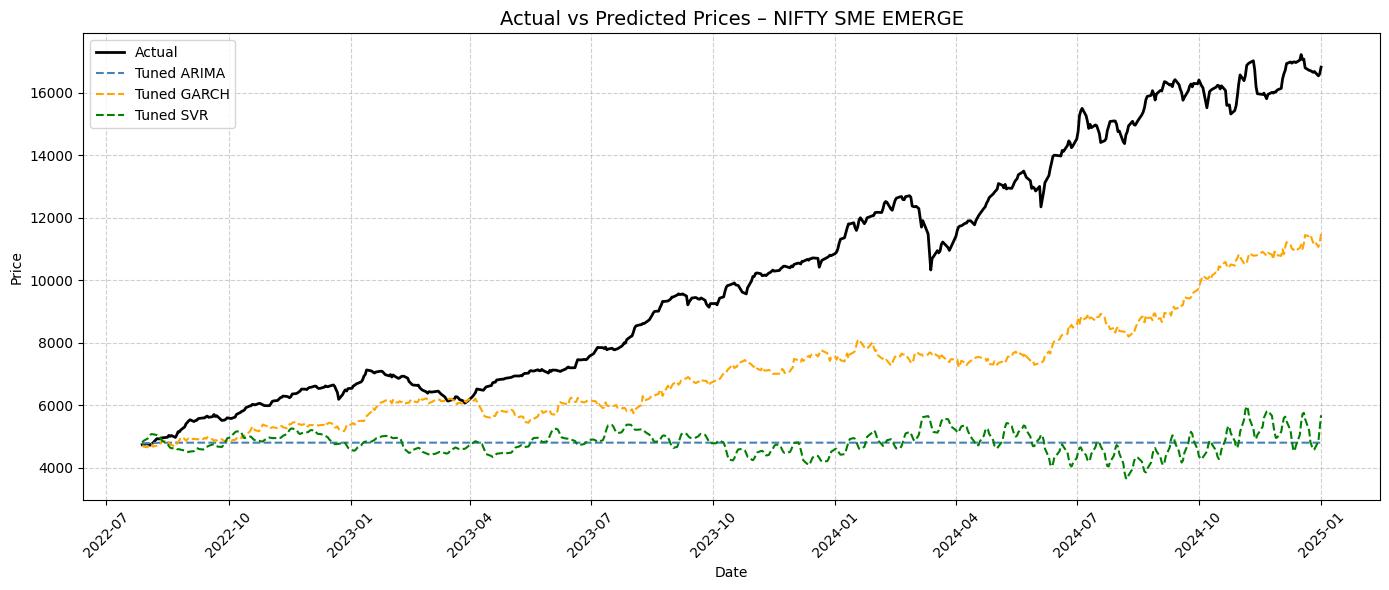

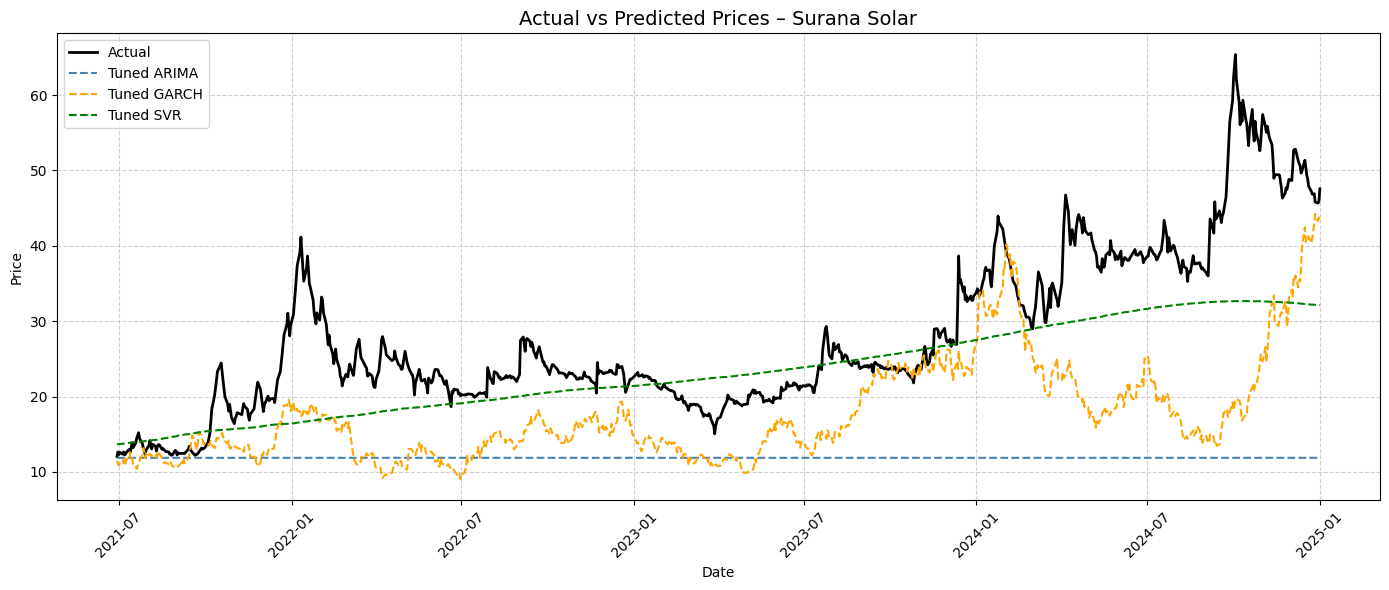

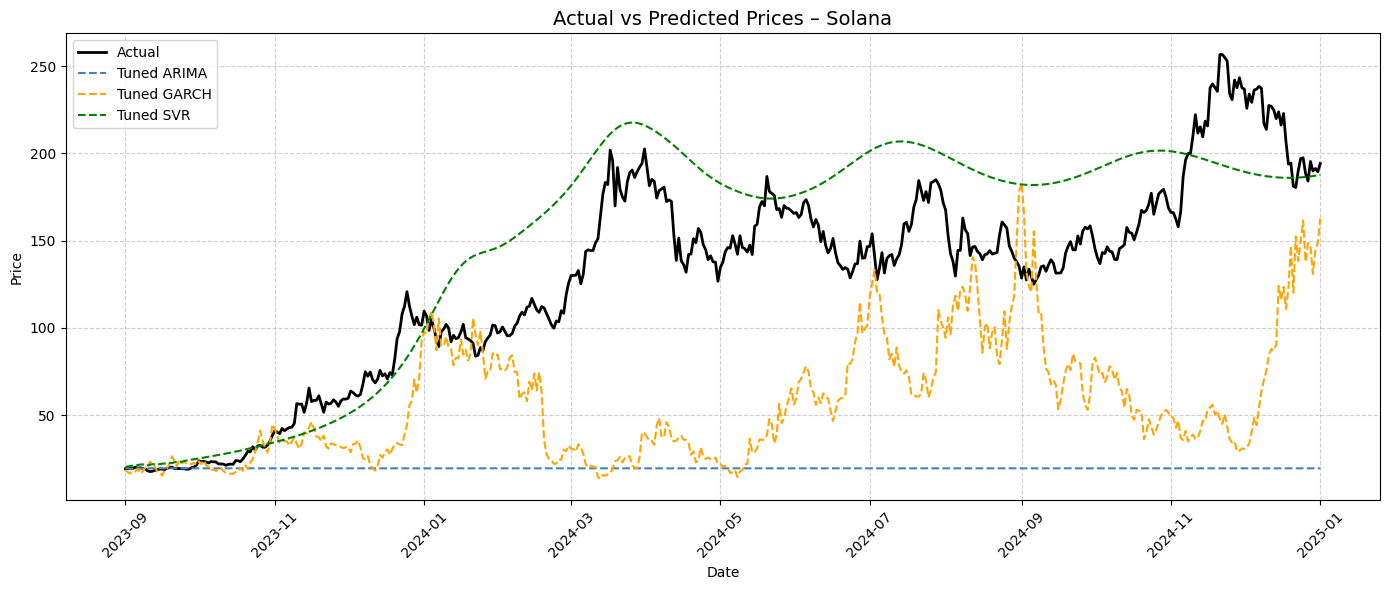

In [120]:
unified_predictions = {}
datasets = ['Clean Power Hydrogen', 'NIFTY SME EMERGE', 'Surana Solar', 'Solana']

for name in datasets:
    # Construct SVR dataframe
    svr_data = svr_tuned_results[name]
    svr_df = pd.DataFrame({
        "Date": svr_data["val_dates"],
        "Actual_Close": svr_data["actual"],
        "SVR_Pred": svr_data["predicted"]
    })

    # Rename columns in ARIMA and GARCH tuned predictions
    arima_df = arima_predictions[name].rename(columns={"Predicted_Close": "ARIMA_Pred"})
    garch_df = final_mse_garch_predictions[name].rename(columns={"MSE_GARCH_Predicted_Close": "GARCH_Pred"})

    # Merge all three on the same index
    merged_df = arima_df[[ "Actual_Close", "ARIMA_Pred"]].copy()
    merged_df["GARCH_Pred"] = garch_df["GARCH_Pred"].values
    merged_df["SVR_Pred"] = svr_df["SVR_Pred"].values
    merged_df = merged_df.rename(columns={"Actual_Close": "Actual"})

    # Store
    unified_predictions[name] = merged_df


    
def plot_predictions(df, dataset_name):
    plt.figure(figsize=(14, 6))

    plt.plot( df['Actual'], label='Actual', color='black', linewidth=2)
    plt.plot( df['ARIMA_Pred'], label='Tuned ARIMA', linestyle='--', color='steelblue')
    plt.plot( df['GARCH_Pred'], label='Tuned GARCH', linestyle='--', color='orange')
    plt.plot( df['SVR_Pred'], label='Tuned SVR', linestyle='--', color='green')

    plt.title(f'Actual vs Predicted Prices – {dataset_name}', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_predictions(unified_predictions['Clean Power Hydrogen'], 'Clean Power Hydrogen')
plot_predictions(unified_predictions['NIFTY SME EMERGE'], 'NIFTY SME EMERGE')
plot_predictions(unified_predictions['Surana Solar'], 'Surana Solar')
plot_predictions(unified_predictions['Solana'], 'Solana')
